# Урок №6. Домашнее задание.

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [5]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [6]:
from sklearn.datasets import load_diabetes

In [7]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)


$$a_{N}(x) = \sum^{N}_{n=1}\eta\gamma_{n}b_{n}(x).$$

In [9]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)])
                     for x in X])

In [29]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [30]:
def bias(y, z):
    return -2 * (z - y)

Функция градиентного бустинга:

In [38]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей позиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [132]:
n_trees = 25

coefs = [1] * n_trees

max_depth = 3

eta = 0.5

In [133]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [134]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')
    
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    
    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [135]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.5 на тренировочной выборке: 413
Ошибка алгоритма из 25 деревьев глубиной 3     с шагом 0.5 на тестовой выборке: 5264


In [136]:
import matplotlib.pyplot as plt

%matplotlib inline

In [137]:
def get_error_plot(n_trees, test_err):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(1, n_trees+1)), test_err, label='test error')
    plt.plot(list(range(1, n_trees+1)), train_err, label='train error')
    plt.legend(loc='upper right')

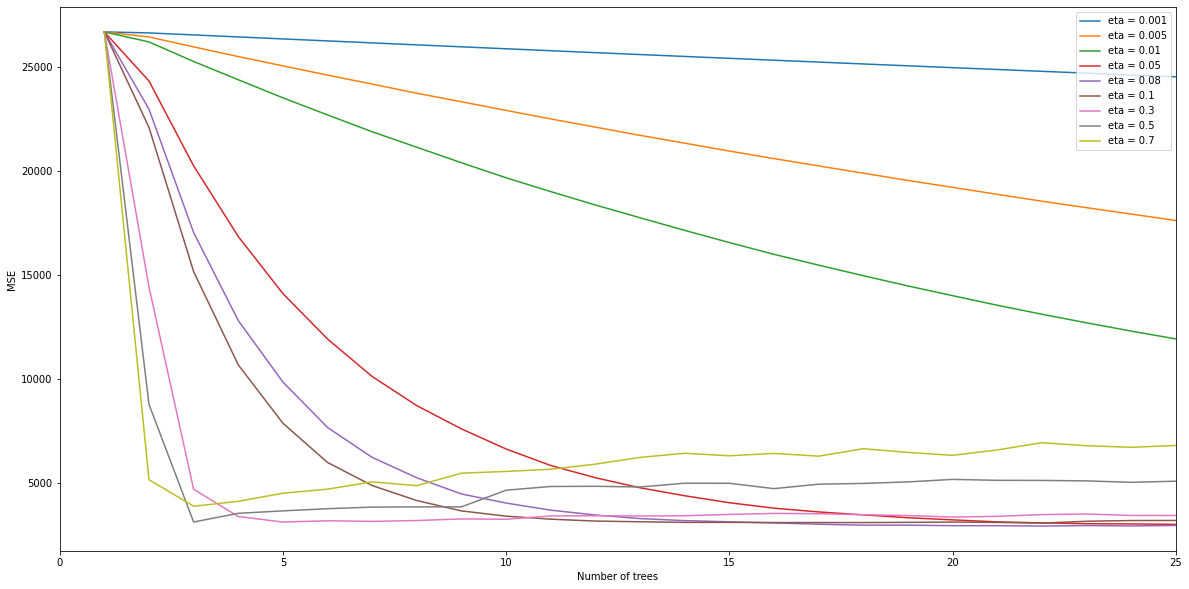

In [138]:
a = [0.001, 0.005, 0.01, 0.05, 0.08, 0.1, 0.3, 0.5, 0.7]
plt.figure(figsize=(20, 10))
for eta in a:
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    plt.plot(list(range(1, n_trees+1)), test_errors, label=f'eta = {eta}')
    plt.legend(loc='upper right')

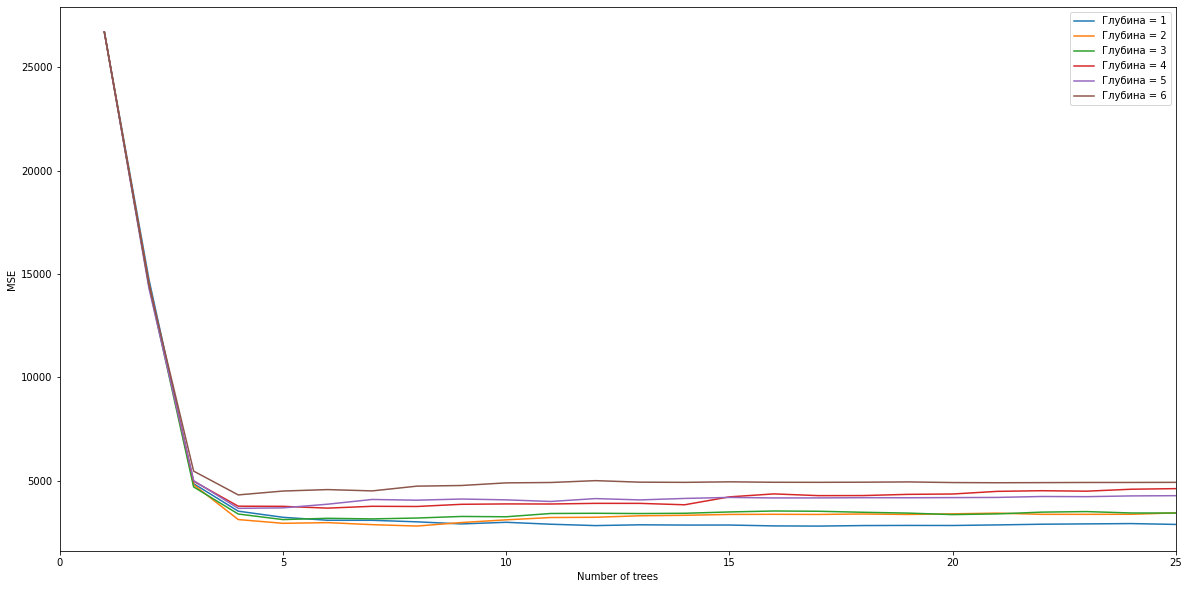

In [139]:
eta = 0.3
plt.figure(figsize=(20, 10))
for max_depth in np.arange(1, 7):
    plt.xlabel('Number of trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    plt.plot(list(range(1, n_trees+1)), test_errors, label=f'Глубина = {max_depth}')
    plt.legend(loc='upper right')

- **Шаг градиента**: при уменьшении шага градиента возникает потребность в более высоком количестве деревьев в бустинге для приближения к сходимости, но также есть возможность более точно увидеть момент, когда значение среднеквадратичной ошибки в тесте начинает расходиться с тренировочной (переобучение), и это может потребовать больше времени и затрат мощностей компьютера.
- **Глубина деревьев**: при увеличении глубины деревьев возникает большая переобученность модели на тренировочных данных, что влечет за собой увеличение среднеквадратичной ошибки в тесте.
- **Количество деревьев**: на графиках видно, что при увеличении количества деревьев в зависимости от гиперпараметров в какой-то момент возникает "выпрямление" среднеквадратичной ошибки на тесте в лучшем случае, либо происходит ее увеличение.

**Подбор гиперпараметров**

In [143]:
a = [0.05, 0.08, 0.1, 0.3, 0.5, 0.7]

Минимальное значение МSE на тесте 3180.3546874270396 при eta = 0.05, max_depth = 1
Минимальное значение МSE на тесте 2987.1914814101174 при eta = 0.05, max_depth = 2
Минимальное значение МSE на тесте 2989.9807093372815 при eta = 0.05, max_depth = 3
Минимальное значение МSE на тесте 3144.985200382922 при eta = 0.05, max_depth = 4
Минимальное значение МSE на тесте 2908.559190536711 при eta = 0.08, max_depth = 1
Минимальное значение МSE на тесте 2816.5995680427095 при eta = 0.08, max_depth = 2
Минимальное значение МSE на тесте 2916.249033737736 при eta = 0.08, max_depth = 3
Минимальное значение МSE на тесте 3244.2988724965057 при eta = 0.08, max_depth = 4
Минимальное значение МSE на тесте 2809.9631526214716 при eta = 0.1, max_depth = 1
Минимальное значение МSE на тесте 2937.68806291336 при eta = 0.1, max_depth = 2
Минимальное значение МSE на тесте 3060.8114255038977 при eta = 0.1, max_depth = 3
Минимальное значение МSE на тесте 3167.5404300537575 при eta = 0.1, max_depth = 4
Минимальное з

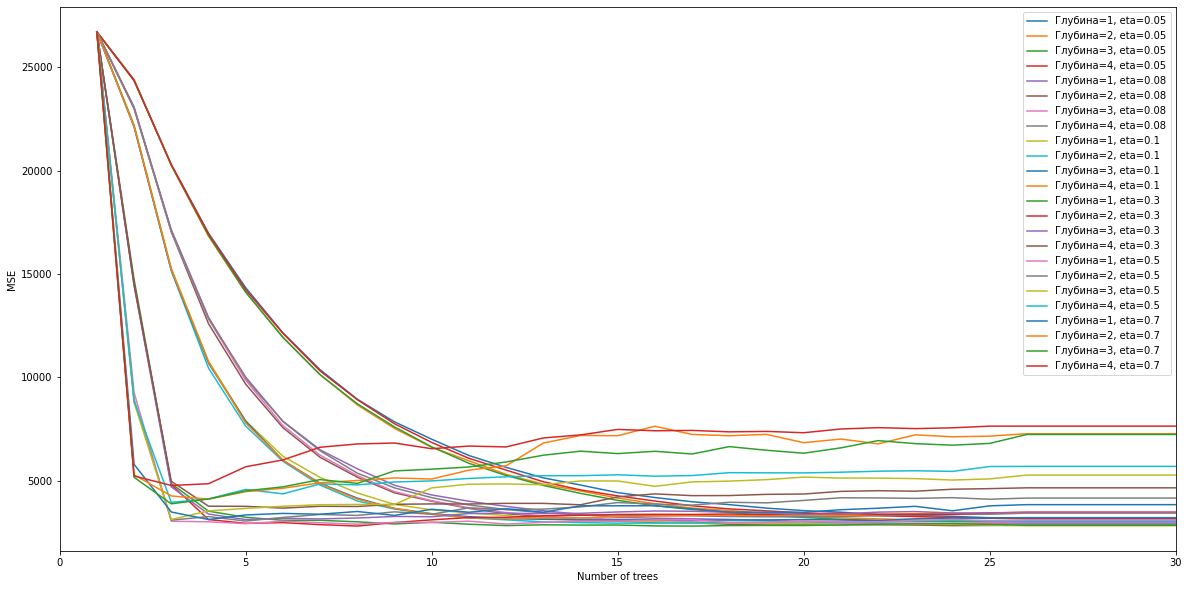

In [145]:
plt.figure(figsize=(20, 10))
n_trees = 30
for eta in a:
    for max_depth in np.arange(1, 5):
        plt.xlabel('Number of trees')
        plt.ylabel('MSE')
        plt.xlim(0, n_trees)
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        plt.plot(list(range(1, n_trees+1)), test_errors, label=f'Глубина={max_depth}, eta={eta}')
        plt.legend(loc='upper right')
        print(f'Минимальное значение МSE на тесте {min(test_errors)} при eta = {eta}, max_depth = {max_depth}')

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

3. (\*) Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.